In [ ]:
#hide
path_to_repository = 'tabnet'
library_name       = 'tabnet'
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/{path_to_repository}'
!pip3 install -e . -q
!pip3 install nbdev -q
!pip3 install fastai==2.5.2 -q

Mounted at /content/drive
/content/drive/MyDrive/tabnet
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 51 kB 267 kB/s 
     |████████████████████████████████| 56 kB 3.5 MB/s 
     |████████████████████████████████| 186 kB 31.4 MB/s 


In [ ]:
# default_exp core

# TabNet

> Implementation of tabnet paper.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastai.tabular.all import *
from torch.autograd     import Function

In [ ]:
#export
path = untar_data(URLs.ADULT_SAMPLE)

In [ ]:
#export
df = pd.read_csv(path / 'adult.csv')
cat_names  = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num'] 

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [ ]:
#export
def get_emb_sz(to, sz_dict=None):
    "Get default embedding size from `TabularPreprocessor` `proc` or the ones in `sz_dict`"
    return [_one_emb_sz(to.classes, n, sz_dict) for n in to.cat_names]

def _one_emb_sz(classes, n, sz_dict=None):
    "Pick an embedding size for `n` depending on `classes` if not given in `sz_dict`."
    sz_dict = ifnone(sz_dict, {})
    n_cat = len(classes[n])
    sz = sz_dict.get(n, int(emb_sz_rule(n_cat)))  # rule of thumb
    return n_cat,sz

def emb_sz_rule(n_cat):
    "Rule of thumb to pick embedding size corresponding to `n_cat`"
    return min(600, round(1.6 * n_cat**0.56))

In [ ]:
#export

np.random.seed(41)
splits = RandomSplitter()(range_of(df))

cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'
y_block = CategoryBlock()

to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, y_block=y_block, splits=splits)

In [ ]:
#export
dls = to.dataloaders(bs=4096)
emb_szs = get_emb_sz(to)

## Notes


### Main components of the paper

  - TabNetEncoder
    - Feature Transformer
      - Primitive Block
        - FC + Ghost BN + GLU
    - Attention Transformer
      - FC, BN, Priors and SparseMax
    - Split

  - TabNetDecoder

### How to create a primitive block?
  - Primitive Block consists of FC ( fully-connected ) layer, ghost batch norm and GLU ( Gated Linear Unit ).
  - According to design mentioned in the paper we have to support construction of multiple of these blocks.

### What is the notion of decision step?
  - Decision step is when we run tabnet encoder multiple times.

### What is a shared decision unit?
  - During multiple runs of the tabnet encoder the section of the feature transformer that would share weights across the runs.

### What is an independent decision unit?
  - During multiple runs of the tabnet encoder the section of the feature transformer that would not share weights across the runs.

### Which components of the primitive blocks are parameterized?
  - FC
  - Ghost BN ( batch_size, momentum )

### What is meant by muliple copies of the primitive block?
  - So the paper proposes to try out building multiple different copies of the primitive block, every copy would require us to initialize different parameters which could or could not be shared across different decision steps.

### Notes:
  - In this architecture we are assuming that shared layer would always come before the independent decision step layer, but what would happend there is no shared layer and we only want independent decision layer.
  - Also in feature transformer, Linear layer takes input_dim to be #features and output dimension would be 2 * (n_d + n_a) where n_d represents `dimension of the prediction layer` and n_a represents `dimension of the attention layer`.

### Todos:
  - [x] initialize glu layer particular linear layer with xavier initializaion, look at fastai docs to see how linear layer is initialized in the module.
  - [x] Attention Module
  - [x] Split Module
  - [x] Loss function
  - [x] Introduce $\lambda_{sparse}$ and add it to the overall loss.
  - [ ] TabNetDecoder ( for self-supervised learning )
  - [ ] Explainable AI through global and instance level feature importance.
  - [ ] How to fit decoder network in the cycle.

## Helper Methods

In [ ]:
#export
def init_glu_linear(module, input_dim, output_dim):
    gain_value = np.sqrt((input_dim + output_dim) / np.sqrt(4 * input_dim))
    nn.init.xavier_normal_(module.weight, gain=gain_value)

def init_non_glu_linear(module, input_dim, output_dim):
    gain_value = np.sqrt((input_dim + output_dim) / np.sqrt(input_dim))
    torch.nn.init.xavier_normal_(module.weight, gain=gain_value)

## Trainable Embeddings

In [ ]:
#export
class TNEMbedding(Module):
  "Embedding layer used in Tab Net"
  def __init__(self, emb_szs, n_cont):
      self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
      n_emb = sum(e.embedding_dim for e in self.embeds)
      self.n_emb,self.n_cont = n_emb,n_cont
      sizes = [n_emb + n_cont]
      
  def forward(self, x_cat, x_cont=None):
      """
      Runs through categorical features and transform them into
      embeding based on the `emb_szs` passed in the layer constructor.
      It then concatenates the remaining continuous features if any with
      the embeddings.
      """

      if self.n_emb != 0:
          x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
          x = torch.cat(x, 1)
      
      if self.n_cont != 0:
          x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
      
      return x

## Ghost Batch Normalization

In [ ]:
#export
class GBN(Module):
    """
    Ghost Batch Normalization
    https://arxiv.org/abs/1705.08741
    """

    def __init__(self, inp_dim, vbs=128, mom=0.01):
        store_attr()
        self.bn = nn.BatchNorm1d(self.inp_dim, momentum=self.mom)

    def forward(self, x):
        chunks = x.chunk(int(np.ceil(x.shape[0] / self.vbs)), 0)
        res    = [self.bn(x_) for x_ in chunks]
        return torch.cat(res, dim=0)

## GLU Block

In [ ]:
#export
class GLUBlock(Module):
  def __init__(self, inp_dim, out_dim, fc=None, vbs=128, mom=0.02):
    store_attr()

    self.fc = ifnone(fc, nn.Linear(inp_dim, 2 * out_dim, bias=False))
    init_glu_linear(self.fc, inp_dim, 2 * out_dim)
    
    self.bn = GBN(2 * out_dim, vbs=vbs, mom=mom)

  def forward(self, x):
    out = self.fc(x)
    out = self.bn(out)
    out = torch.mul(out[:, : self.out_dim], torch.sigmoid(out[:, self.out_dim :]))
    return out

## Feature Transformer

In [ ]:
#export
class FeatureTransformer(Module):
  def __init__(self, inp_dim, out_dim, n_d, n_a, n_sh, n_ind, vbs, mom):
    store_attr()

    self.fcs    = self._make_fc(n_sh)
    self.sh_ds  = self._make_shared_blocks()
    self.ind_ds = self._make_ind_blocks() 

  
  def _make_fc(self, n):
    return nn.ModuleList([nn.Linear(self.inp_dim, 
                                    2 * (self.n_d + self.n_a), 
                                    bias=False) if i == 0 else \
                          nn.Linear(self.n_d + self.n_a, 
                                    2 * (self.n_d + self.n_a),
                                    bias=False
                                    ) for i in range(n)])

  def _make_shared_blocks(self):
    return nn.ModuleList([GLUBlock(self.inp_dim, 
                                    self.out_dim, 
                                    fc=self.fcs[i], 
                                    vbs=self.vbs, 
                                    mom=self.mom) if i == 0 else\
                           GLUBlock(self.out_dim, 
                                    self.out_dim, 
                                    fc=self.fcs[i], 
                                    vbs=self.vbs, 
                                    mom=self.mom) for i in range(self.n_sh)])
    
  def _make_ind_blocks(self):
    return nn.ModuleList([GLUBlock(self.out_dim, 
                                   self.out_dim, 
                                   fc=None, 
                                   vbs=self.vbs, 
                                   mom=self.mom) for i in range(self.n_ind)]
                         )

  def forward(self, x):
    scale = torch.sqrt(torch.FloatTensor([0.5])).to(x.device)

    out = self.sh_ds[0](x)
    
    for i in range(1, len(self.sh_ds)):
      out = torch.add(out, self.sh_ds[i](out))
      out = out * scale

    for i in range(len(self.ind_ds)):
      out = torch.add(out, self.ind_ds[i](out))
      out = out * scale
    
    return out

## Sparsemax

In [ ]:
#export
# credits to Yandex https://github.com/Qwicen/node/blob/master/lib/nn_utils.py
def _make_ix_like(input, dim=0):
    d = input.size(dim)
    rho = torch.arange(1, d + 1, device=input.device, dtype=input.dtype)
    view = [1] * input.dim()
    view[0] = -1
    return rho.view(view).transpose(0, dim)


class SparsemaxFunction(Function):
    """
    An implementation of sparsemax (Martins & Astudillo, 2016). See
    :cite:`DBLP:journals/corr/MartinsA16` for detailed description.
    By Ben Peters and Vlad Niculae
    """

    @staticmethod
    def forward(ctx, input, dim=-1):
        """sparsemax: normalizing sparse transform (a la softmax)
        Parameters
        ----------
        ctx : torch.autograd.function._ContextMethodMixin
        input : torch.Tensor
            any shape
        dim : int
            dimension along which to apply sparsemax
        Returns
        -------
        output : torch.Tensor
            same shape as input
        """
        ctx.dim = dim
        max_val, _ = input.max(dim=dim, keepdim=True)
        input -= max_val  # same numerical stability trick as for softmax
        tau, supp_size = SparsemaxFunction._threshold_and_support(input, dim=dim)
        output = torch.clamp(input - tau, min=0)
        ctx.save_for_backward(supp_size, output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        supp_size, output = ctx.saved_tensors
        dim = ctx.dim
        grad_input = grad_output.clone()
        grad_input[output == 0] = 0

        v_hat = grad_input.sum(dim=dim) / supp_size.to(output.dtype).squeeze()
        v_hat = v_hat.unsqueeze(dim)
        grad_input = torch.where(output != 0, grad_input - v_hat, grad_input)
        return grad_input, None

    @staticmethod
    def _threshold_and_support(input, dim=-1):
        """Sparsemax building block: compute the threshold
        Parameters
        ----------
        input: torch.Tensor
            any dimension
        dim : int
            dimension along which to apply the sparsemax
        Returns
        -------
        tau : torch.Tensor
            the threshold value
        support_size : torch.Tensor
        """

        input_srt, _ = torch.sort(input, descending=True, dim=dim)
        input_cumsum = input_srt.cumsum(dim) - 1
        rhos = _make_ix_like(input, dim)
        support = rhos * input_srt > input_cumsum

        support_size = support.sum(dim=dim).unsqueeze(dim)
        tau = input_cumsum.gather(dim, support_size - 1)
        tau /= support_size.to(input.dtype)
        return tau, support_size


sparsemax = SparsemaxFunction.apply

class Sparsemax(nn.Module):
    def __init__(self, dim=-1):
        self.dim = dim
        super(Sparsemax, self).__init__()

    def forward(self, input):
        return sparsemax(input, self.dim)

## Attentive Transformer

In [ ]:
#export
class AttentiveTransformer(Module):
  def __init__(self, inp_dim, out_dim, vbs, mom, mask_type):
    store_attr()
    self.fc = nn.Linear(inp_dim, out_dim, bias=False)
    init_non_glu_linear(self.fc, inp_dim, out_dim)
    
    self.bn = GBN(out_dim, vbs=vbs, mom=mom)

    mask_type = ifnone(mask_type, 'sparsemax')
    if mask_type == 'sparsemax': self.sel = Sparsemax(dim=-1)

  def forward(self, priors, proc_feat):
    out = self.fc(proc_feat)
    out = self.bn(out)
    out = torch.mul(out, priors)
    out = self.sel(out)
    return out

## TabNetEncoder

In [ ]:
#export
class TabNetEncoder(Module):
  def __init__(self, 
               inp_dim, 
               out_dim,
               n_d,
               n_a,
               n_ds,
               gamma=1.3,
               n_ind=2,
               n_sh=2,
               eps=1e-15,
               vbs=128,
               mom=0.02,
               mask_type='sparsemax'
               ):
    
    store_attr()
    self.init_bn = nn.BatchNorm1d(self.inp_dim, momentum=0.01)
    self.init_ft = FeatureTransformer(inp_dim,
                                      n_d + n_a,
                                      n_d,
                                      n_a,
                                      n_sh, 
                                      n_ind, 
                                      vbs, 
                                      mom
                                      )
    
    # based on number of decision steps we would create module
    # list of transformers and attentive transformers
    self.fts = nn.ModuleList()
    self.ats = nn.ModuleList()

    for i in range(n_ds):
      ft = FeatureTransformer(inp_dim,
                              n_d + n_a,
                              n_d,
                              n_a,
                              n_sh, 
                              n_ind, 
                              vbs, 
                              mom
                              )
      
      # attentive transformer is always preceded by 
      # feature transformer hence inp_dim would be 
      # `n_d + n_a`
      
      at = AttentiveTransformer(n_a,
                                inp_dim,
                                vbs=vbs,
                                mom=mom,
                                mask_type=mask_type
                                )
      
      self.fts.append(ft)
      self.ats.append(at)

  def forward(self, x, priors=None):
    x = self.init_bn(x)

    priors = ifnone(priors, torch.ones(x.shape).to(x.device))

    M_loss = 0
    att    = self.init_ft(x)[:, self.n_d:] # this could be configured

    steps_out = []

    for step in range(self.n_ds):
      M = self.ats[step](priors, att)
      M_loss += torch.mean(torch.sum(torch.mul(M, torch.log(M + self.eps)), dim=1)
                          )
      
      # update prior
      priors = torch.mul(self.gamma - priors, priors)

      # output
      masked_x = torch.mul(M, x)
      out      = self.fts[step](masked_x)
      d        = nn.ReLU()(out[:, :self.n_d])

      steps_out.append(d)

      # update attention
      att = out[:, self.n_d:]

    M_loss /= self.n_ds
    return steps_out, M_loss

## TabNet



In [ ]:
#export
class TabNet(Module):
  def __init__(self,
               emb_szs, 
               n_cont,
               out_dim,
               n_d=2,
               n_a=2,
               n_ds=2,
               gamma=1.3,
               n_ind=2,
               n_sh=2,
               eps=1e-15,
               vbs=128,
               mom=0.02,
               mask_type="sparsemax",
               ):
    
    store_attr()
    self.tnembed = TNEMbedding(emb_szs, n_cont)
    self.encoder = TabNetEncoder(inp_dim=self.tnembed.n_emb + n_cont, 
                                out_dim=out_dim,
                                n_d=n_d,
                                n_a=n_a,
                                n_ds=n_ds,
                                gamma=gamma,
                                n_ind=n_ind,
                                n_sh=n_sh,
                                eps=eps,
                                vbs=vbs,
                                mom=mom,
                                mask_type=mask_type
                                )
    
    self.final_mapping = nn.Linear(n_d, out_dim, bias=False)
    init_non_glu_linear(self.final_mapping, n_d, out_dim)

  def forward(self, x_cat, x_cont):
    x  = self.tnembed(x_cat, x_cont)

    res = 0
    steps_output, M_loss = self.encoder(x)
    res = torch.sum(torch.stack(steps_output, dim=0), dim=0)
    out = self.final_mapping(res)
    
    return out, M_loss

## Loss Function

In [ ]:
#export
class TabNetLoss(Module):
  def __init__(self, lambda_sparse:float):
    store_attr()
    self.loss_fn = CrossEntropyLossFlat()
  
  def forward(self, os, target):
      output, M_loss = os
      tot            = self.loss_fn(output, target) +\
                       M_loss * self.lambda_sparse
      return tot

## Usage

In [ ]:
#hide
model = TabNet(emb_szs=get_emb_sz(to),
             n_cont=len(to.cont_names), 
             out_dim=dls.c, 
             n_d=16, 
             n_a=16,
             n_ds=5, 
             n_sh=2,
             n_ind=2, 
             gamma=1.5,
             vbs=128, 
             mom=0.02
            )

In [ ]:
#hide
def custom_accuracy(inps, targ, axis=-1):
  "Compute accuracy with `targ` when `pred` is bs * n_classes"
  inp, _ = inps
  pred,targ = flatten_check(inp.argmax(dim=axis), targ)
  return (pred == targ).float().mean()

In [ ]:
#hide
lambda_sparse = 1e-4
learn = Learner(dls, model, TabNetLoss(lambda_sparse), opt_func=ranger, metrics=[custom_accuracy])

In [ ]:
#hide
lambda_sparse = 1e-4
opt_func = partial(Adam, wd=0.01, eps=1e-5)
learn = Learner(dls, model, TabNetLoss(lambda_sparse), opt_func=opt_func, lr=1e-2, metrics=[custom_accuracy])

SuggestedLRs(valley=0.013182567432522774)

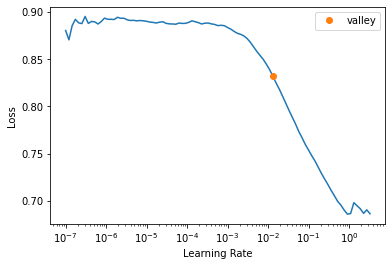

In [ ]:
#hide
learn.lr_find()

In [ ]:
#hide
learn.fit_flat_cos(40, lr=1e-2)

epoch,train_loss,valid_loss,custom_accuracy,time
0,0.945846,0.518069,0.769656,00:04
1,0.757278,0.549525,0.755221,00:04
2,0.675667,0.512002,0.765817,00:04
3,0.620661,0.497234,0.777027,00:04
4,0.581336,0.490098,0.775184,00:04
5,0.549457,0.481839,0.790694,00:04
6,0.523759,0.468211,0.794533,00:04
7,0.502621,0.461106,0.801904,00:04
8,0.485134,0.455618,0.800369,00:04
9,0.470272,0.444955,0.801136,00:04
